In [1]:
import numpy as np
from numpy import *
import lab2_proto as proto
import lab2_tools as tools
import prondict as pron
from lab2_proto import *
from lab2_tools import *
from prondict import *
import matplotlib.pyplot as plt
from tqdm import tqdm

In [43]:
phoneHMMs = np.load('lab2_models_onespkr.npz', allow_pickle=True)['phoneHMMs'].item()

In [44]:
pro = pron.prondict
isolated = {}
for digit in pro.keys():
    isolated[digit] = ['sil'] + pro[digit] + ['sil']

In [45]:
phoneHMMs = np.load('lab2_models_onespkr.npz', allow_pickle=True)['phoneHMMs'].item()
pro = pron.prondict
isolated = {}
for digit in pro.keys():
    isolated[digit] = ['sil'] + pro[digit] + ['sil']
wordHMMs = {}
wordHMMs['o'] = proto.concatHMMs(phoneHMMs, isolated['o'])
for uterance in isolated:
    wordHMMs[uterance] = concatHMMs(phoneHMMs,isolated[uterance])
# print(wordHMMs['o'])

In [46]:
example = np.load('lab2_example.npz',allow_pickle=True)['example'].item()

In [47]:
list(example.keys())
example['lmfcc'].shape
example['obsloglik'].shape

(71, 9)

(71, 13)
(9, 13)
(71, 9)


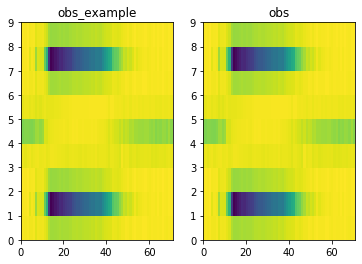

In [34]:
obsloglik = tools.log_multivariate_normal_density_diag(example['lmfcc'],wordHMMs['o']['means'],wordHMMs['o']['covars'])
print(example['lmfcc'].shape)
print(wordHMMs['o']['means'].shape)
print(obsloglik.shape)
fig, ax = plt.subplots(ncols=2)
ax[0].pcolormesh(example['obsloglik'].T)
ax[0].set_title('obs_example')
ax[1].set_title('obs')
ax[1].pcolormesh(obsloglik.T)
plt.show()


## The figure is exactly the same as in example\['obsloglik'\].  The components '1','7' give the lowest likelihood in timesteps between 10-40.
Why?(???I don't know)

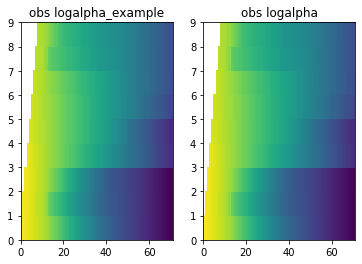

In [8]:
log_startprob = np.log(wordHMMs['o']['startprob'])
log_transmat = np.log(wordHMMs['o']['transmat'])
log_alpha,_ = forward(obsloglik,log_startprob,log_transmat)
fig, ax = plt.subplots(ncols=2)
ax[0].pcolormesh(example['logalpha'].T)
ax[0].set_title('obs logalpha_example')
ax[1].set_title('obs logalpha')
ax[1].pcolormesh(log_alpha.T)
plt.show()

In [9]:
data = np.load('lab2_data.npz',allow_pickle=True)['data']

In [10]:
maxLikelihoods = []
maxll = -inf
maxll_model = ''

for sample in tqdm(data):
    digit = sample['digit']
    maxll = -inf 
    dic = {}
    for hmm in wordHMMs:
        obsll = log_multivariate_normal_density_diag(sample['lmfcc'],
                                                       wordHMMs[hmm]['means'],
                                                       wordHMMs[hmm]['covars'])
        log_startprob_tmp = np.log(wordHMMs[hmm]['startprob'])
        log_transmat_tmp = np.log(wordHMMs[hmm]['transmat'])

        _,obs_seq_ll = forward(obsll,log_startprob_tmp,log_transmat_tmp)

        if obs_seq_ll > maxll:
            maxll = obs_seq_ll
            maxll_model = hmm

    dic['gender'] = sample['gender']
    dic['digit'] = digit 
    dic['model'] = maxll_model
    dic['max_ll'] = int(maxll)
    
    maxLikelihoods.append(dic)

100%|██████████| 44/44 [00:18<00:00,  2.32it/s]


In [11]:
print("man acc:",12/22)
print("woman acc:",1)
maxLikelihoods

man acc: 0.5454545454545454
woman acc: 1


[{'gender': 'man', 'digit': 'o', 'model': 'o', 'max_ll': -6755},
 {'gender': 'man', 'digit': 'o', 'model': 'o', 'max_ll': -6097},
 {'gender': 'man', 'digit': 'z', 'model': 'z', 'max_ll': -8118},
 {'gender': 'man', 'digit': 'z', 'model': 'z', 'max_ll': -7687},
 {'gender': 'man', 'digit': '1', 'model': '3', 'max_ll': -6997},
 {'gender': 'man', 'digit': '1', 'model': '9', 'max_ll': -7198},
 {'gender': 'man', 'digit': '2', 'model': '3', 'max_ll': -6227},
 {'gender': 'man', 'digit': '2', 'model': '2', 'max_ll': -7520},
 {'gender': 'man', 'digit': '3', 'model': '3', 'max_ll': -7245},
 {'gender': 'man', 'digit': '3', 'model': '3', 'max_ll': -8101},
 {'gender': 'man', 'digit': '4', 'model': '4', 'max_ll': -7227},
 {'gender': 'man', 'digit': '4', 'model': '4', 'max_ll': -7191},
 {'gender': 'man', 'digit': '5', 'model': '3', 'max_ll': -7699},
 {'gender': 'man', 'digit': '5', 'model': '3', 'max_ll': -7053},
 {'gender': 'man', 'digit': '6', 'model': '6', 'max_ll': -8062},
 {'gender': 'man', 'digit

## All speaker

In [59]:
phoneHMMs = np.load('lab2_models_all.npz', allow_pickle=True)['phoneHMMs'].item()
pro = pron.prondict
isolated = {}
for digit in pro.keys():
    isolated[digit] = ['sil'] + pro[digit] + ['sil']
wordHMMs = {}
wordHMMs['o'] = proto.concatHMMs(phoneHMMs, isolated['o'])
for uterance in isolated:
    wordHMMs[uterance] = concatHMMs(phoneHMMs,isolated[uterance])

In [18]:
maxLikelihoods = []
maxll = -inf
maxll_model = ''

for sample in tqdm(data):
    digit = sample['digit']
    maxll = -inf 
    dic = {}
    for hmm in wordHMMs:
        obsll = log_multivariate_normal_density_diag(sample['lmfcc'],
                                                       wordHMMs[hmm]['means'],
                                                       wordHMMs[hmm]['covars'])
        log_startprob_tmp = np.log(wordHMMs[hmm]['startprob'])
        log_transmat_tmp = np.log(wordHMMs[hmm]['transmat'])

        _,obs_seq_ll = forward(obsll,log_startprob_tmp,log_transmat_tmp)

        if obs_seq_ll > maxll:
            maxll = obs_seq_ll
            maxll_model = hmm

    dic['gender'] = sample['gender']
    dic['digit'] = digit 
    dic['model'] = maxll_model
    dic['max_ll'] = int(maxll)
    
    maxLikelihoods.append(dic)

100%|██████████| 44/44 [00:19<00:00,  2.22it/s]


In [20]:
print("man acc:",1)
print("woman acc:",21/22)
maxLikelihoods

man acc: 1
woman acc: 0.9545454545454546


[{'gender': 'man', 'digit': 'o', 'model': 'o', 'max_ll': -6475},
 {'gender': 'man', 'digit': 'o', 'model': 'o', 'max_ll': -5821},
 {'gender': 'man', 'digit': 'z', 'model': 'z', 'max_ll': -7760},
 {'gender': 'man', 'digit': 'z', 'model': 'z', 'max_ll': -7376},
 {'gender': 'man', 'digit': '1', 'model': '1', 'max_ll': -6609},
 {'gender': 'man', 'digit': '1', 'model': '1', 'max_ll': -6778},
 {'gender': 'man', 'digit': '2', 'model': '2', 'max_ll': -6003},
 {'gender': 'man', 'digit': '2', 'model': '2', 'max_ll': -7202},
 {'gender': 'man', 'digit': '3', 'model': '3', 'max_ll': -6957},
 {'gender': 'man', 'digit': '3', 'model': '3', 'max_ll': -7735},
 {'gender': 'man', 'digit': '4', 'model': '4', 'max_ll': -6826},
 {'gender': 'man', 'digit': '4', 'model': '4', 'max_ll': -6793},
 {'gender': 'man', 'digit': '5', 'model': '5', 'max_ll': -7282},
 {'gender': 'man', 'digit': '5', 'model': '5', 'max_ll': -6619},
 {'gender': 'man', 'digit': '6', 'model': '6', 'max_ll': -7721},
 {'gender': 'man', 'digit

## Viterbi

In [12]:
viterbi_loglik, viterbi_path = viterbi(obsloglik,log_startprob,log_transmat)
print(viterbi_loglik,viterbi_path)
print(example['vloglik'],example['vpath'])


-5974.211288357338 [0 1 1 1 2 2 2 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 6 6 6 7 8 8 8 8 8 8 8 8 8 8]
-5974.211288357338 [0 1 1 1 2 2 2 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 6 6 6 7 8 8 8 8 8 8 8 8 8 8]


[]

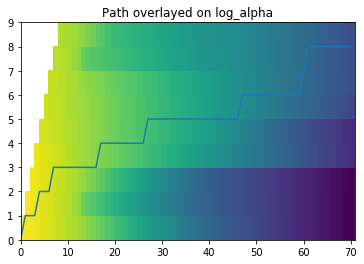

In [13]:
plt.pcolormesh(np.ma.masked_invalid(log_alpha).T)
plt.plot( np.arange(len(viterbi_path)),viterbi_path)
plt.title("Path overlayed on log_alpha")
plt.plot()

In [20]:
maxLikelihoods = []
maxll = -inf
maxll_model = ''

for sample in tqdm(data):
    digit = sample['digit']
    maxll = -inf 
    dic = {}
    for hmm in wordHMMs:
        obsll = log_multivariate_normal_density_diag(sample['lmfcc'],
                                                       wordHMMs[hmm]['means'],
                                                       wordHMMs[hmm]['covars'])
        log_startprob_tmp = np.log(wordHMMs[hmm]['startprob'])
        log_transmat_tmp = np.log(wordHMMs[hmm]['transmat'])

        obs_seq_ll,_ = viterbi(obsll,log_startprob_tmp,log_transmat_tmp)

        if obs_seq_ll > maxll:
            maxll = obs_seq_ll
            maxll_model = hmm

    dic['gender'] = sample['gender']
    dic['digit'] = digit 
    dic['model'] = maxll_model
    dic['max_ll'] = int(maxll)
    
    maxLikelihoods.append(dic)

100%|██████████| 44/44 [00:10<00:00,  4.18it/s]


In [22]:
print("man acc",12/22)
maxLikelihoods

man acc 0.5454545454545454


[{'gender': 'man', 'digit': 'o', 'model': 'o', 'max_ll': -6757},
 {'gender': 'man', 'digit': 'o', 'model': 'o', 'max_ll': -6100},
 {'gender': 'man', 'digit': 'z', 'model': 'z', 'max_ll': -8120},
 {'gender': 'man', 'digit': 'z', 'model': 'z', 'max_ll': -7690},
 {'gender': 'man', 'digit': '1', 'model': '3', 'max_ll': -6998},
 {'gender': 'man', 'digit': '1', 'model': '9', 'max_ll': -7200},
 {'gender': 'man', 'digit': '2', 'model': '3', 'max_ll': -6229},
 {'gender': 'man', 'digit': '2', 'model': '2', 'max_ll': -7521},
 {'gender': 'man', 'digit': '3', 'model': '3', 'max_ll': -7247},
 {'gender': 'man', 'digit': '3', 'model': '3', 'max_ll': -8104},
 {'gender': 'man', 'digit': '4', 'model': '4', 'max_ll': -7231},
 {'gender': 'man', 'digit': '4', 'model': '4', 'max_ll': -7193},
 {'gender': 'man', 'digit': '5', 'model': '3', 'max_ll': -7700},
 {'gender': 'man', 'digit': '5', 'model': '3', 'max_ll': -7054},
 {'gender': 'man', 'digit': '6', 'model': '6', 'max_ll': -8065},
 {'gender': 'man', 'digit

## Backward

In [14]:
beta,logll= backward(obsloglik,log_startprob,log_transmat)

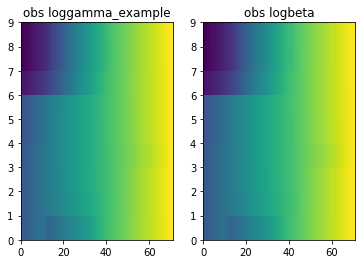

In [15]:
fig, ax = plt.subplots(ncols=2)
ax[0].pcolormesh(example['logbeta'].T)
ax[0].set_title('obs loggamma_example')
ax[1].set_title('obs logbeta')
ax[1].pcolormesh(beta.T)
plt.show()

In [16]:
print(logll)
print(example['loglik'])

-5970.427602563562
-5970.427602563561


## HMM Retraining

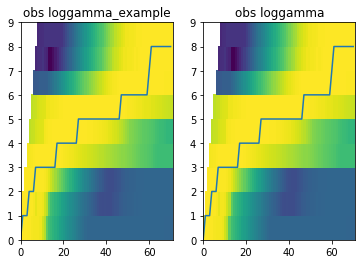

In [17]:
loggamma=statePosteriors(log_alpha, beta)
fig, ax = plt.subplots(ncols=2)
ax[0].pcolormesh(example['loggamma'].T)
ax[0].plot(example['vpath'])
ax[0].set_title('obs loggamma_example')
ax[1].set_title('obs loggamma')
ax[1].plot(viterbi_path)
ax[1].pcolormesh(loggamma.T)
plt.show()

In [60]:
def EM(wordHMM,X,n_iters):
    probs=[]
    ll=0
    iters=0
    for i in range(n_iters):
        #E
        obsloglik = log_multivariate_normal_density_diag(X, wordHMM['means'], wordHMM['covars']) 
        logalphas,_ = forward(obsloglik, np.log(wordHMM['startprob']), np.log(wordHMM['transmat']))
        logbetas,_ = backward(obsloglik, np.log(wordHMM['startprob']), np.log(wordHMM['transmat']))
        # M
        loggammas = statePosteriors(logalphas, logbetas)
        wordHMM['means'], wordHMM['covars'] = updateMeanAndVar(X, loggammas)
        pre_ll=ll
        ll=logsumexp(logalphas[-1])
        if np.allclose(ll, pre_ll):
            iters=i
            break
        probs.append(ll)
    
    return wordHMM,probs,iters

4


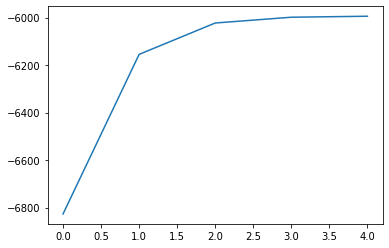

In [61]:
print(data[10]['digit'])
plt.plot(EM(wordHMMs['4'],data[10]['lmfcc'],10)[1])
plt.show()

o : 5
z : 5
1 : 10
2 : 6
3 : 4
4 : 1
5 : 8
6 : 8
7 : 8
8 : 4
9 : 8


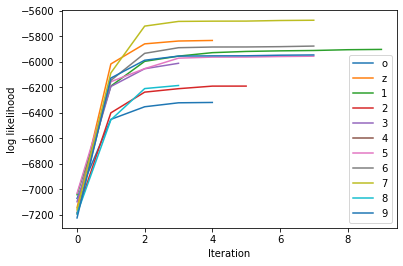

In [62]:
for digit in wordHMMs.keys():
    hmm = wordHMMs[digit].copy()
     # 'four'
    result = EM(hmm,data[10]['lmfcc'],20)
    plt.plot(result[1], label=digit)
    print(digit,":",result[2])
    
plt.xlabel('Iteration')
plt.ylabel('log likelihood')
plt.legend()
plt.show()